# minGRU
Predicting the next word.

Note: this project was completed for CS 479 Assignment 4

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(111) #for reproducibility purposes
np.random.seed(111)

## Read in the data

Note: the data reading code was provided by the CS 479 starter code.

The code below creates a dataset from an excerpt from Charles Darwin's _On the Origin of Species by Natural Selection_ (1859).
  
Each list element represents a sequence of characters. There are 3 ways to represent a character:
1. `c`: As a character, eg. `'b'`
2. `i`: As an index to a character set, eg. `2`
3. `v`: As a one-hot vector, eg. `[0, 0, 1, 0, ...]` (`a` is at index 1)

These utility functions convert sequences between the 3 different representations.
  - `seq_v2i`
  - `seq_v2c`
  - `seq_c2i`
  - `seq_c2v`
  - `seq_i2v`
  - `seq_i2c`

In [2]:
import re
class Origin(torch.utils.data.Dataset):
    def __init__(self, seq_length=10, start=0, stop=-1):
        self.seq_length = seq_length

        orig_text = open('origin_of_species.txt').read().lower()
        chars = sorted(list(set(orig_text)))
        chars.insert(0, "\0") #Add newline character

        char_indices = dict((c, i) for i, c in enumerate(chars))
        indices_char = dict((i, c) for i, c in enumerate(chars))
        idx = [char_indices[c] for c in orig_text]

        # Let's simplify it by keeping only letters and spaces
        filt_idx = []
        for i in idx:
            if i<=24 and i!=10:
                filt_idx.append(2)
            elif i>24 or i==10:
                filt_idx.append(i)
        blah = ''.join([indices_char[f] for f in filt_idx])
        self.text = re.sub(' +', ' ', blah)  # collapse multiple spaces using regular expressions
        self.text = self.text[start:stop]
        chars = sorted(list(set(self.text)))
        self.vocab_size = len(chars)
        print('Character set: \"'+''.join(chars)+'\" (first char is a space)')

        self.char_indices = dict((c, i) for i, c in enumerate(chars))
        self.indices_char = dict((i, c) for i, c in enumerate(chars))
        self.idx = [self.char_indices[c] for c in self.text]

        print('There are '+str(self.vocab_size)+' characters in our character set')

    def __len__(self):
        return len(self.text) - 1 - self.seq_length
    
    def __getitem__(self, k):
        x = self.idx[k:k+self.seq_length]
        t = self.idx[k+1:k+1+self.seq_length]
        return self.seq_i2v(x), torch.tensor(t, dtype=torch.long)
      
    def seq_i2v(self, i):
        '''
        v = oos.seq_i2v(i)
        converts a sequence of indices to a sequence of 1-hot vectors
        i  (T,) tensor
        v  (T,27) tensor
        '''
        x = torch.zeros((len(i), self.vocab_size))
        for k,ii in enumerate(i):
            x[k,ii] = 1.
        return x
    
    def seq_v2i(self, v):
        '''
        i = oos.seq_v2i(v)
        converts a sequence of 1-hot vectors to a sequence of indices
        v  (T,27) tensor
        i  (T,) tensor
        '''
        return torch.tensor([torch.argmax(vv).item() for vv in v])
    
    def seq_i2c(self, i):
        '''
        c = oos.seq_i2c(i)
        converts a sequence of indices to a string
        i  (T,) tensor
        c  string
        '''
        return ''.join(self.indices_char[ii.item()] for ii in i)
    
    def seq_v2c(self, v):
        '''
        c = oos.seq_v2c(v)
        converts a sequence of 1-hot vectors to a string
        v  (T,27) tensor
        c  string
        '''
        i = self.seq_v2i(v)
        return self.seq_i2c(i)
    
    def seq_c2i(self, c):
        '''
        i = oos.seq_c2i(c)
        converts a string to a sequence of indices
        c  string
        i  (T,) tensor
        '''
        return torch.tensor([self.char_indices[cc] for cc in c])
    
    def seq_c2v(self, c):
        '''
        v = oos.seq_c2v(c)
        converts a string to a sequence of 1-hot vectors
        c  string
        v  (T,27) tensor
        '''
        i = self.seq_c2i(c)
        return self.seq_i2v(i)

In [3]:
oos = Origin(start=1000, stop=11016, seq_length=15)

Character set: " .abcdefghijklmnopqrstuvwxy" (first char is a space)
There are 27 characters in our character set


In [4]:
oos.char_indices

{' ': 0,
 '.': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26}

In [5]:
# Number of training sequences
len(oos)

10000

In [6]:
# Total number of characters
len(oos.text)

10016

In [7]:
# Get a sequence, both input and target
x, t = oos.__getitem__(0)

In [8]:
# A sequence of 15 one-hot vectors
x.shape

torch.Size([15, 27])

In [9]:
# Indecies of 15 targets
t

tensor([ 0, 15, 16, 21,  0,  3,  6,  6, 15,  0,  9,  2, 20, 21, 26])

In [10]:
# Convert the input sequence to a string
oos.seq_v2c(x)

'e not been hast'

In [11]:
print('Here is how you can view one of the sample sequences:')
print(f'         Sample input: "{oos.seq_v2c(x)}"')
print(f'Corresponding targets: "{oos.seq_i2c(t)}"')

Here is how you can view one of the sample sequences:
         Sample input: "e not been hast"
Corresponding targets: " not been hasty"


In [12]:
# We'll use this DataLoader for minibatch SGD
dl = torch.utils.data.DataLoader(oos, batch_size=128, shuffle=True)

In [13]:
# Let's get a batch just to see what it looks like.
xb, tb = next(iter(dl))
print(xb.shape)

torch.Size([128, 15, 27])


In [14]:
k = 6
print(f'Taking sequence {k} from the batch:')
print(f'         Sample input: "{oos.seq_v2c(xb[k])}"')
print(f'Corresponding targets:  "{oos.seq_i2c(tb[k])}"')

Taking sequence 6 from the batch:
         Sample input: "e unsatisfactor"
Corresponding targets:  " unsatisfactory"


In [15]:
print(tb[k])

tensor([ 0, 22, 15, 20,  2, 21, 10, 20,  7,  2,  4, 21, 16, 19, 26])


# Q4 (a) Complete `minGRU`

In [16]:
class minGRU(nn.Module):
    '''
     net = minGRU(in_dim, hidden_dim, out_dim, outfcn=nn.LogSoftmax(dim=-1))

     Create a minGRU network.

     Inputs:
      in_dim      dimension of input
      hidden_dim  dimension of hidden layers
      out_dim     dimension of output
      outfcn      activation function for output
                  (default: nn.LogSoftmax(dim=-1))

     Usage:
     > net = minGRU(27, 300, 27, outfcn=nn.Tanh())
     > x = torch.randn((3, 10, 27))  # batch of 3 sequences of length 10
     > y = net(x)
     Returns y with shape (3, 10, 27)
     
     > y = net.step(x[:,0,:].unsqueeze(1))
     Returns y with shape (3, 1, 27)
    '''
    def __init__(self, in_dim, hidden_dim, out_dim, outfcn=nn.LogSoftmax(dim=-1)):
        super().__init__()
        self.in_dim = in_dim          # input dimension
        self.hidden_dim = hidden_dim  # hidden dimension
        self.out_dim = out_dim        # output dimension

        self.h = None
        

        #===== YOUR CODE HERE =====
        self.layers = torch.nn.ModuleList()

        Ug_bg_lyr = torch.nn.Linear(in_dim, hidden_dim) # computes xt @ Ug + bg
        U_b_lyr = torch.nn.Linear(in_dim, hidden_dim) # computes xt @ U + b
        V_by_lyr = torch.nn.Linear(hidden_dim, out_dim) # computes ht @ V + by

        self.layers.append(Ug_bg_lyr)
        self.layers.append(U_b_lyr)
        self.layers.append(V_by_lyr)
        
        self.hiddenfcn = torch.nn.Sigmoid()
        self.outfcn = outfcn
        # self.softmax = torch.nn.Softmax()
        #==========================


        self.losses = []
        self.to(device)
    
    def reset(self):
        self.h = None

    def step(self, x):
        '''
        y = net.step(x)

        Performs one time step of an entire batch, using the input x and the
        saved hidden state (net.h) to generate the output y.
        
        Input:
         x  (batch_size, 1, in_dim) tensor

        Output:
         y  (batch_size, 1, out_dim) tensor
        '''
        _, T, _ = x.shape
        assert T == 1, 'minGRU.step: x must have shape (batch_size, 1, in_dim)'
        if self.h is None:
            self.h = torch.zeros((x.shape[0], 1, self.hidden_dim)).to(device)


        #===== YOUR CODE HERE =====

        gt = self.hiddenfcn(self.layers[0](x))
        ht_tilde = self.layers[1](x)
        self.h = torch.mul(gt, ht_tilde) + torch.mul(1-gt, self.h)
        y = self.outfcn(self.layers[2](self.h))

        #==========================


        return y
        
    def forward(self, x_batch):
        '''
        y = net.forward(x_batch) or y = net(x_batch)

        Performs a forward pass of an entire batch of sequences, using the input x_batch to
        generate the output y.
        The hidden state, h, is carried forward through timesteps but not returned.

        Input:
         x_batch  (batch_size, T, in_dim) tensor

        Output:
         y        (batch_size, T, out_dim) tensor
        '''
        # The input x_batch is a batch of sequences of one-hot vectors.
        samples, T, in_dim = x_batch.shape
        assert in_dim == self.in_dim, 'minGRU.forward: x_batch must have shape (batch_size, T, in_dim)'

        x_batch = x_batch.to(device)   # just in case you have a GPU
        self.reset()
        

        #===== YOUR CODE HERE =====
        # y = torch.zeros((samples, T, self.out_dim)).to(device) # <= replace this line
        y = None
        for i in range(T):
            # yt shape: (batch_size, 1, out_dim)
            yt = self.step(x_batch[:,i,:].unsqueeze(1))
            if y != None:
                y = torch.cat([y, yt], dim=1)
            else:
                y = yt
        #==========================


        return y

# Q4 (b) Complete `DeepminGRU`

In [17]:
class DeepminGRU(nn.Module):
    '''
    net = DeepminGRU(n_layers, in_dim, hidden_dim)

    Creates a deep minGRU network with n_layers layers, where the input
    to each minGRU layer has in_dim neurons, and the hidden layer has
    hidden_dim neurons.

    The output of the last (top) layer should use a LogSoftmax activation
    function.

    Usage:
    > net = DeepminGRU(3, 27, 300)
    > x = torch.randn((3, 10, 27))  # batch of 3 sequences of length 10
    > y = net(x)
    Returns y with shape (3, 10, 27)

    > y = net.step(x[:,0,:].unsqueeze(1))
    Returns y with shape (3, 1, 27), where y[n,0,:] is the log of a probability vector
    '''
    def __init__(self, n_layers, in_dim, hidden_dim):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.losses = []


        #===== YOUR CODE HERE =====
        # Add some minGRU layers
        self.layers = torch.nn.ModuleList()
        self.n_layers = n_layers
        for i in range(n_layers):
            if i < n_layers - 1:
                # use tanh activation for intermediate layers
                outfcn = torch.nn.Tanh()
            else:
                outfcn = torch.nn.LogSoftmax(dim=-1)

            self.layers.append(minGRU(in_dim, hidden_dim, in_dim, outfcn))

        #==========================


        self.to(device)

    def reset(self):
        for l in self.layers:
            l.reset()

    # output: (batch_size, 1, out_dim)
    def step(self, x):
        
        #===== YOUR CODE HERE =====
        next_input = x

        for lyr in self.layers:
            next_input = lyr.step(next_input)

        x = next_input
        #==========================

        return x
    
    # output: (batch_size, T, out_dim)
    def forward(self, x):


        #===== YOUR CODE HERE =====
        # Add some minGRU layers
        input_batch = x

        for lyr in self.layers:
            input_batch = lyr(input_batch)

        x = input_batch
        #==========================

        return x
                
    def predict(self, x, n=10):
        '''
        y = net.predict(x, n=10)

        Given a sequence of one-hot vectors x, predict the next n
        outputs.

        Inputs:
         x  (1, T, in_dim) tensor, where T is the length of the sequence
         n  int, the number of outputs to predict

        Outputs:
         y  (1, n, out_dim) tensor of probability vectors
        '''
        with torch.no_grad():
            assert x.shape[0] == 1, 'predict: x must have shape (1, T, in_dim)'
            assert x.shape[2] == self.in_dim, 'predict: x must have shape (1, T, in_dim)'
            # output = torch.zeros((1, n+1, self.in_dim)).to(device)
            output = torch.zeros((1, n, self.in_dim)).to(device)

            self.reset()  # Reset all hidden states


            #===== YOUR CODE HERE =====
            
            # get the first next character
            if n >= 1:
                # shape (1, T, out_dim)
                log_output_probs = self(x)
                out_dim = log_output_probs.shape[-1]
                output_probs = torch.exp(log_output_probs)
                # shape (1, T)
                output_classes = torch.argmax(output_probs, dim=2)

                # shape (1,T, out_dim)
                output_one_hot = torch.nn.functional.one_hot(output_classes, out_dim)

                # shape (out_dim)
                output[0, 0] = output_one_hot[0, -1].view(1,1,-1)
                
            # shape (1,1,out_dim)
            cur_input = output[0, 0].view(1,1,out_dim)

            # get remaining n-1 next characters after the first one
            # keep feeding the next character back into the network using step()
            for i in range(1,n):
                # shape (1, 1, out_dim)
                log_output_prob_next_char = self.step(cur_input)
                output_prob_next_char = torch.exp(log_output_prob_next_char)
                # shape (1, 1)
                output_class_next_char = torch.argmax(output_prob_next_char, dim=2)

                # shape (1,1, out_dim)
                output_one_hot = torch.nn.functional.one_hot(output_class_next_char, out_dim)
                
                # shape (1,1,out_dim)
                output[0, i] = output_one_hot[0, -1].view(1,1,-1)
                cur_input = output[0, i].view(1,1,out_dim)

            #==========================


        return output
    
    def bptt(self, dl, epochs=10, lr=0.001):
        '''
        net.bptt(dl, epochs=10, lr=0.001)
        Perform backprop-through-time (BPTT) to learn from the sequences in the dataset.
         dl      Dataloader object (see above)
         epochs  How many epochs to train for
         lr      Learning rate
        '''
        loss_fcn = nn.NLLLoss()
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in (dl):
                y = self(x)
                # Loss is summed over time steps
                loss = torch.tensor(0., device=device, requires_grad=True)
                for k in range(t.shape[1]):
                    ys = y[:,k,:].squeeze()
                    ts = t[:,k]
                    loss = loss + loss_fcn(ys, ts)
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item() * len(t)
            self.losses.append(total_loss/len(dl.dataset))
        print(self.losses)
        plt.plot(self.losses)

# Q4 (c) Train it

100%|██████████| 50/50 [01:43<00:00,  2.07s/it]

[36.04929477539063, 28.745495791625977, 24.89831304321289, 22.37505096435547, 20.23371933288574, 18.87514627075195, 17.70054126586914, 16.688851190185545, 15.791585513305664, 15.223031225585938, 14.78416093902588, 14.24240394744873, 13.726957287597656, 13.3767644821167, 13.088829350280761, 12.784024160766602, 12.489003700256347, 12.276075340270996, 12.165133013916016, 11.96875030822754, 11.649128332519531, 11.567455282592773, 11.403691355895996, 11.244020712280273, 11.12987713470459, 11.050809742736817, 10.963475747680665, 11.011483836364746, 10.8251383102417, 10.857504689025879, 10.690390649414063, 10.638859524536132, 10.624187062072753, 10.464736141967773, 10.471623292541503, 10.432620713806152, 10.253279693603515, 10.203229795837402, 10.318805792236327, 10.126201930236816, 10.082330184936524, 10.04547509765625, 10.024981973266602, 10.22302628479004, 10.059028239440918, 10.012157453918457, 9.877293299865723, 9.803299122619629, 9.79387043762207, 9.871779473876954]


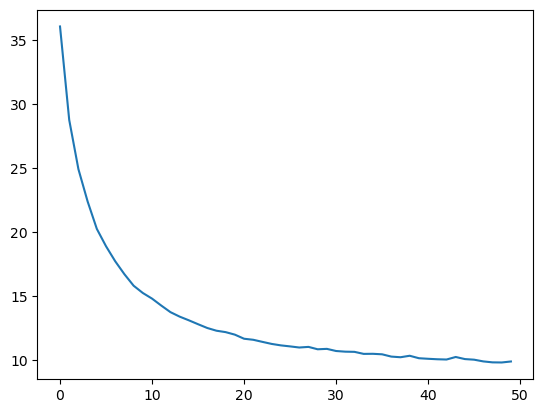

In [18]:
net = DeepminGRU(2, oos.vocab_size, 500)
net.bptt(dl, epochs=50, lr=0.008)

100%|██████████| 50/50 [02:04<00:00,  2.49s/it]

[36.52581975097656, 29.49601628417969, 25.905922998046876, 23.49277258605957, 21.70829627380371, 20.285424307250977, 18.95048576965332, 18.025295245361328, 17.102579292297364, 16.294176626586914, 15.618757966613769, 15.083633738708496, 14.678536610412598, 14.182378166198731, 13.768515809631348, 13.486997471618652, 13.186027061462402, 12.952423294067383, 12.68587960205078, 12.509867008972169, 12.250150462341308, 12.116183940124511, 11.886552085876465, 11.700163928222656, 11.639908894348144, 11.486215786743164, 11.407859579467774, 11.223331968688965, 11.097821757507324, 10.959849938964844, 11.021859358215332, 10.766847465515136, 10.76731083984375, 10.723073655700684, 10.584690887451172, 10.557578594970703, 10.46889801940918, 10.317889836120605, 10.276114932250977, 10.133872244262696, 10.145226609802245, 10.15101881866455, 10.131896440124512, 10.047668946838378, 10.008577772521972, 9.887837609863281, 9.811520967102052, 9.806940928649903, 9.793417985534669, 9.807838409423828]


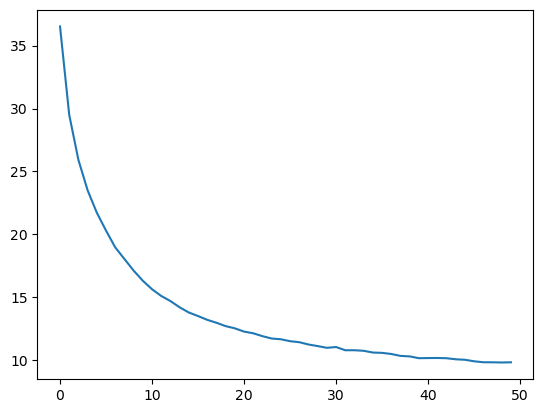

In [19]:
net = DeepminGRU(2, oos.vocab_size, 500)
net.bptt(dl, epochs=50, lr=0.006)

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]

[37.03864164428711, 30.512824221801758, 27.285240603637696, 24.953507400512695, 23.177552731323242, 21.777316302490235, 20.427076055908202, 19.535137481689453, 18.528558471679688, 17.794778137207032, 17.066529373168944, 16.44447752685547, 15.971242797851563, 15.386807354736328, 14.92420210571289, 14.607096731567383, 14.130816990661621, 13.827885243225097, 13.494159661865234, 13.269717420959473, 13.087267890930177, 12.765743110656738, 12.629427581787109, 12.316808081054688, 12.199351843261718, 12.000919413757325, 11.861662010192871, 11.738991384887695, 11.492387413024902, 11.401650843811035, 11.33538628692627, 11.172747575378418, 11.078637110900878, 10.942799287414552, 10.914722743225097, 10.789047296142579, 10.814829243469239, 10.708756838989258, 10.468371287536621, 10.533790469360351, 10.330673065185547, 10.414503462219239, 10.293622463989259, 10.232293797302246, 10.222193395996094, 10.218951315307617, 10.05689183807373, 9.962998780822755, 9.965311590576173, 10.016181507873535]


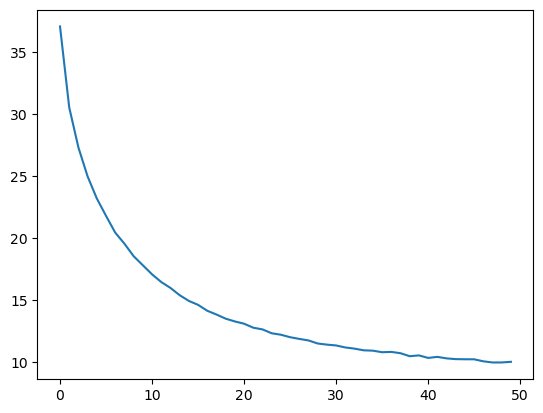

In [ ]:
net = DeepminGRU(2, oos.vocab_size, 500)
net.bptt(dl, epochs=50, lr=0.005)

In [ ]:
# You can save and re-load your model if you choose.
# torch.save(net.cpu(), 'origin_500dh.pt')
# net = torch.load('origin.pt').to(device)

# Q4 (d) Next-Letter Prediction Accuracy

In [21]:
#===== YOUR CODE HERE =====
# Get last output for each sequence in the dataset

# Check if the last output matches the target

# Report what fraction of the 9984 sequences yielded the correct next letter


N = 10000 # 128 * num_batches + 16. 16 is the size of last batch
num_correct = 0

for x,t in (dl):
    B = x.shape[0]
    for i in range(B):
        # shape (1,1,out_dim)
        next_c = net.predict(x[i].unsqueeze(0), 1)
        if (torch.argmax(next_c) == t[i, -1]):
            num_correct += 1

    # print(x.shape, t.shape)

print("Next letter accuracy", num_correct/N)
#==========================


Next letter accuracy 0.9282


# Q4 (e) Predict the next 160 characters

In [22]:
# Choose a sequence randomly
v,t = oos.__getitem__(np.random.randint(len(oos)))

# Or enter your own prompt (don't be rude)
#v = oos.seq_i2v([oos.char_indices[cc] for cc in 'higher forms'])

# Use v.unsqueeze(0) to make it a batch with one sequence

# Predict the next 160 characters


#===== YOUR CODE HERE =====

# shape (1, n, out_dim)
pred_vectors = net.predict(v.unsqueeze(0), n=160)
pred_text = oos.seq_v2c(pred_vectors.squeeze())
#==========================


print(f'{oos.seq_v2c(v.squeeze())}\033[31m{pred_text[:70]}\033[0m')
print(f'\033[31m{pred_text[70:]}\033[0m')

. i may venture to express my conviction of the whole animal and which i formerly ent
ertained namely first the structure of the case of the conclusions have coadaptation. . va
